## Apple Product Sentiment Analysis

### by Monica Pecha, Sam Choe, and Daniel Fox

### Overview

This project utilized Natural Language Processing (NLP) to understand the sentiment of Apple products from the 2011 SXSW conference in Austin, Texas. The objective was to build a model that can rate the sentiment of a tweet based on its text.

### Business Understanding

Apple data advisory group - for apple to better understand sentiment of products

### Data Understanding and Limitations
The dataset comes from CrowdFlower via data.world. The initial dataset contains three features (tweet text, product creator, and human derived sentiment) and 9093 rows regarding both Google and Apple products. 


Limitations include that tweets focused on Apple products in relation to the SXSW conference in 2011 and may not be generalizable across non conference participants over time. After VADER sentiment analysis was implemented spot checks indicated that there were several tweets that were not classified correctly. 

### Table of Contents
- Exploratory Data Analysis
    - Synthesizing additional data
    - Implementing VADER
- Preprocessing
- Models
    - Count Vectorization
    - Term Frequency - Inverse Document Frequency (Tfidf) Vectorization
    - Random Forest Classifier
    

### Exploratory Data Analysis (EDA)

In [190]:
# Bringing in packages for EDA, pre-processing, modeling, and visualizations
#from collections import defaultdict
import numpy as np
import pandas as pd

import nltk
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, plot_confusion_matrix, recall_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from PIL import Image
import os

from collections import Counter
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [191]:
# Reading in the original dataset
df = pd.read_csv("data/judge-1377884607_tweet_product_company.csv", encoding="ISO-8859-1")

In [192]:
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [193]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [194]:
df["emotion_in_tweet_is_directed_at"].value_counts()

iPad                               946
Apple                              661
iPad or iPhone App                 470
Google                             430
iPhone                             297
Other Google product or service    293
Android App                         81
Android                             78
Other Apple product or service      35
Name: emotion_in_tweet_is_directed_at, dtype: int64

In [195]:
df["is_there_an_emotion_directed_at_a_brand_or_product"].value_counts()

No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

In [196]:
# Enter differnt numbers after .iloc in [#] to spot check the text of tweets
df["tweet_text"].iloc[4]

"@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)"

In [197]:
# Defining keywords to diferentiate between Google and Apple product tweets
apple_keywords = ['iPad', 'IPad', 'i-Pad', 'IPAD', 'iphone', 'iPhone', 'Iphone', 'i-phone', 'I-Phone', 'Apple', 'apple', 'Ipad', 'ipad', 'iTunes','Mac', 'IPhone', 'IPHONE']
google_keywords = ['google', 'android', 'Google', 'Android', 'samsung', 'GOOGLE']

def find_brand(text):
    if isinstance(text, str):
        for word in apple_keywords:
            if word in text:
                return "Apple" 
        for word in google_keywords:
            if word in text:
                return "Google" 
    return 'No_Product'

df['product'] = df['tweet_text'].apply(find_brand)

In [198]:
# Reviewing new product category based on the definition created in the cell above
df['product'].value_counts()

Apple         5587
Google        2771
No_Product     735
Name: product, dtype: int64

In [199]:
# Looking for null values in 'product'
df['product'].isna().sum()

0

In [200]:
df['product'].head()

0     Apple
1     Apple
2     Apple
3     Apple
4    Google
Name: product, dtype: object

In [201]:
# Converting strings to integers and combining 'neutral'/'no emotion toward brand or product' with 'unknown'/'I can't tell'
# 0 = negative, 1 = neutral, and 2 = positive
# Renaming 'is_there_an_emotion_directed_at_a_brand_or_product' to 'emotion'
mapping = {"Positive emotion": 2, "No emotion toward brand or product": 1, "I can't tell": 1, "Negative emotion": 0}
df['emotion'] = df["is_there_an_emotion_directed_at_a_brand_or_product"].map(mapping)

In [202]:
# Reviewing new emotion category based on the definition created in the cell above
df["emotion"].value_counts()

1    5545
2    2978
0     570
Name: emotion, dtype: int64

In [203]:
# Use 1 to show all info in cell below then comment it out and use 2 to go back to default view

#1
#pd.set_option('display.max_rows', None)
#pd.set_option('display.max_colwidth', None)

#2
pd.reset_option('display.max_rows')
pd.reset_option('display.max_colwidth')

In [204]:
#exploring 'No_Product' tweets
filtered_df = df[df['product'] == 'No_Product']

print(filtered_df['tweet_text'])

6                                                     NaN
51      ÛÏ@mention {link} &lt;-- HELP ME FORWARD THIS...
52      ÷¼ WHAT? ÷_ {link} ã_ #edchat #musedchat #s...
53      .@mention @mention on the location-based 'fast...
65      Agree. RT @mention Wait. FIONA APPLE is in tow...
                              ...                        
8936    CLIENT NEWS! @mention Releases &quot;Dope Melo...
8958    iPAD / #SXSW PEOPLE: @mention brilliant Spider...
8970    This is my 5th year downloading the #sxsw Musi...
9024    by the way, we're looking for a spanish-speaki...
9026    True story! RT @mention I just rated Amy's Ice...
Name: tweet_text, Length: 735, dtype: object


In [205]:
# Dataframe with regrouped product and emotion categories
df2 = df[["tweet_text", "product", "emotion"]]

In [206]:
# Creating an Apple product only dataframe
df2_apple = df2[df2['product'] == "Apple"]

In [207]:
df2_apple.head()

,tweet_text,product,emotion
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,Apple,0
1,@jessedee Know about @fludapp ? Awesome iPad/i...,Apple,2
2,@swonderlin Can not wait for #iPad 2 also. The...,Apple,2
3,@sxsw I hope this year's festival isn't as cra...,Apple,0
5,@teachntech00 New iPad Apps For #SpeechTherapy...,Apple,1


In [208]:
df2_apple.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5587 entries, 0 to 9091
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   tweet_text  5587 non-null   object
 1   product     5587 non-null   object
 2   emotion     5587 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 174.6+ KB


In [209]:
# The emotion in the dataset in not balanced
df2_apple["emotion"].value_counts(normalize=True)

1    0.540720
2    0.383748
0    0.075532
Name: emotion, dtype: float64

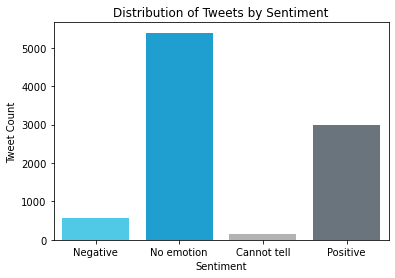

In [341]:
# Visualizing the imbalanced dataset --this is the entire initial dataset, not just Apple products
fig, ax = plt.subplots()

custom_palette = ['#36d8ff', '#00acee', '#b3b3b3', '#66757f']

classes = ['Negative emotion', 'No emotion toward brand or product', "I can't tell", 'Positive emotion']
sns.countplot(x='is_there_an_emotion_directed_at_a_brand_or_product', data=df, palette=custom_palette, order=classes)

ax.set(xticklabels=['Negative', 'No emotion', 'Cannot tell','Positive'], 
       xlabel='Sentiment', ylabel='Tweet Count', title='Distribution of Tweets by Sentiment')

plt.savefig('images/fig0.png', dpi=200, transparent=True)
plt.show()

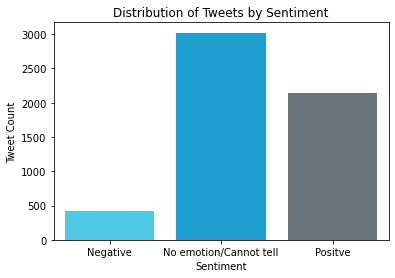

In [211]:
# Visualizing the imbalanced dataset --this is the initial dataset for Apple products only
fig, ax = plt.subplots()


classes = [0, 1, 2]
sns.countplot(x='emotion', data=df2_apple, palette=custom_palette, order=classes)

ax.set(xticklabels=['Negative', 'No emotion/Cannot tell', 'Positve'], 
       xlabel='Sentiment', ylabel='Tweet Count', title='Distribution of Tweets by Sentiment')

plt.savefig('images/fig1.png', dpi=200, transparent=True)
plt.show()

<p> To address the "emotion" feature class inbalance we attempted to scrape down tweets from Twitter about Apple products with negative sentiment. The code for this process can be found in the Twitter_scraping_template notebook found in the GitHub repo Apple Product Sentiment Analysis. The scraping was unsuccessful due to access issues:<p>

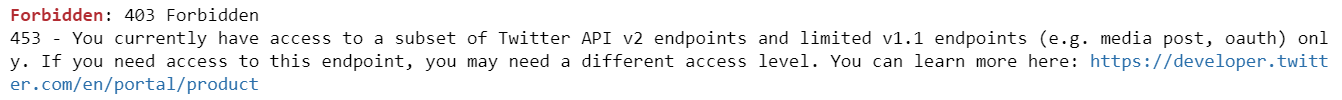

In [212]:
# In order to address the class imbalance we generated tweets with negative sentiment regarding Apple products using ChatGPT
df_new_tweets = pd.read_excel("data/Tweets_SyntheticGeneration_20240503.xlsx")

In [213]:
# The new ChatGPT tweets dataframe
df_new_tweets

,Unnamed: 0,Unnamed: 1
0,"1. ""Bought the latest iPhone, and it's already...","""Bought the latest iPhone, and it's already g..."
1,"1. ""Just got the new iPhone, and it's already ...",NaN
2,"1. ""Just tried out the original iPhone... what...",NaN
3,"1. ""Just tried the iPad 2 at #SXSW... disappoi...",NaN
4,"1. ""The iPod Nano 3rd Generation was a disappo...",NaN
...,...,...
1763,"846. ""The iPod Classic's interface is outdated...",NaN
1764,"847. ""Tried the MacBook... heavy, outdated, an...",NaN
1765,"848. ""The iPod Shuffle's lack of screen and co...",NaN
1766,"849. ""Just saw the iPhone 4... reception issue...",NaN


In [214]:
# Naming the new tweets dataframe columns
df_new_tweets.columns = ['tweet_text', 'extra_col']

In [215]:
# ChatGPT generated several duplicate tweets that we then removed from the dataset
df_new_tweets_clean = df_new_tweets.drop_duplicates(subset='tweet_text')

In [216]:
df_new_tweets_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1719 entries, 0 to 1767
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   tweet_text  1719 non-null   object
 1   extra_col   1 non-null      object
dtypes: object(2)
memory usage: 40.3+ KB


In [217]:
df_new_tweets_clean['product'] = 'Apple'

<ipython-input-217-55661c2f5466>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new_tweets_clean['product'] = 'Apple'


In [218]:
df_new_tweets_clean.head()

,tweet_text,extra_col,product
0,"1. ""Bought the latest iPhone, and it's already...","""Bought the latest iPhone, and it's already g...",Apple
1,"1. ""Just got the new iPhone, and it's already ...",NaN,Apple
2,"1. ""Just tried out the original iPhone... what...",NaN,Apple
3,"1. ""Just tried the iPad 2 at #SXSW... disappoi...",NaN,Apple
4,"1. ""The iPod Nano 3rd Generation was a disappo...",NaN,Apple


In [219]:
# Define a regular expression pattern to match any number followed by a period and a space
pattern = r'^\d+\.\s'

In [220]:
# Need to remove the numbers in front of the tweets
df_new_tweets_clean['tweet_text'][3]

'1. "Just tried the iPad 2 at #SXSW... disappointed doesn\'t even begin to describe it. Same old design, same old issues. #iPad2 #letdown"'

In [221]:
# Iterate through the dataframe column and remove the matching pattern using regex
df_new_tweets_clean['tweet_text'] = df_new_tweets_clean['tweet_text'].map(lambda x: re.sub(pattern, '', x))

<ipython-input-221-4be8770b532e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new_tweets_clean['tweet_text'] = df_new_tweets_clean['tweet_text'].map(lambda x: re.sub(pattern, '', x))


In [222]:
df_new_tweets_clean.head()

,tweet_text,extra_col,product
0,"""Bought the latest iPhone, and it's already gl...","""Bought the latest iPhone, and it's already g...",Apple
1,"""Just got the new iPhone, and it's already cra...",NaN,Apple
2,"""Just tried out the original iPhone... what a ...",NaN,Apple
3,"""Just tried the iPad 2 at #SXSW... disappointe...",NaN,Apple
4,"""The iPod Nano 3rd Generation was a disappoint...",NaN,Apple


In [223]:
df2_apple.head()

,tweet_text,product,emotion
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,Apple,0
1,@jessedee Know about @fludapp ? Awesome iPad/i...,Apple,2
2,@swonderlin Can not wait for #iPad 2 also. The...,Apple,2
3,@sxsw I hope this year's festival isn't as cra...,Apple,0
5,@teachntech00 New iPad Apps For #SpeechTherapy...,Apple,1


In [224]:
df_combo = pd.concat([df2_apple, df_new_tweets_clean], axis=0)

In [225]:
######## MP: what if we left emotion in the dataset and then did a comparison of the columns, if not statistically, simply or visually
######## is this in some way our baseline model? Manual sentiment assignment?

In [226]:
# Dropping unnecessary columns to prepare for VADER
columns_to_drop = ['extra_col', 'emotion']
df_combo.drop(columns=columns_to_drop, inplace=True)

In [227]:
df_combo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7306 entries, 0 to 1767
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   tweet_text  7306 non-null   object
 1   product     7306 non-null   object
dtypes: object(2)
memory usage: 171.2+ KB


In [228]:
#!pip install vaderSentiment

In [229]:
# Initialize VADER sentiment analyzer to predict sentiment of Apple product tweets
analyzer = SentimentIntensityAnalyzer()

# Drop NaN values or replace with empty strings 
df_combo['tweet_text'].fillna('', inplace=True) 

# Analyze sentiment for each tweet and add the scores to the DataFrame
df_combo['sentiment'] = df_combo['tweet_text'].apply(lambda tweet: analyzer.polarity_scores(tweet))

# Extract compound sentiment score from the sentiment dictionary
df_combo['compound_score'] = df_combo['sentiment'].apply(lambda score_dict: score_dict['compound'])

# Function to categorize compound score into positive, negative, or neutral
def categorize_sentiment(score):
    if score > 0.05:
        return '2'
    elif score < -0.05:
        return '0'
    else:
        return '1'

# Apply the function to create a new column with sentiment category
df_combo['emotion'] = df_combo['compound_score'].apply(categorize_sentiment)

print(df_combo[['tweet_text', 'compound_score', 'emotion']])

                                             tweet_text  compound_score  \
0     .@wesley83 I have a 3G iPhone. After 3 hrs twe...         -0.6800   
1     @jessedee Know about @fludapp ? Awesome iPad/i...          0.9100   
2     @swonderlin Can not wait for #iPad 2 also. The...          0.0000   
3     @sxsw I hope this year's festival isn't as cra...          0.7269   
5     @teachntech00 New iPad Apps For #SpeechTherapy...          0.0000   
...                                                 ...             ...   
1763  "The iPod Classic's interface is outdated. Tim...          0.0000   
1764  "Tried the MacBook... heavy, outdated, and not...         -0.5812   
1765  "The iPod Shuffle's lack of screen and control...         -0.6369   
1766  "Just saw the iPhone 4... reception issues are...         -0.5209   
1767  "The iPad 2 is a disappointment. Expected more...         -0.3892   

     emotion  
0          0  
1          2  
2          1  
3          2  
5          1  
...      

In [230]:
df_combo.head()

,tweet_text,product,sentiment,compound_score,emotion
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,Apple,"{'neg': 0.173, 'neu': 0.827, 'pos': 0.0, 'comp...",-0.6800,0
1,@jessedee Know about @fludapp ? Awesome iPad/i...,Apple,"{'neg': 0.0, 'neu': 0.59, 'pos': 0.41, 'compou...",0.9100,2
2,@swonderlin Can not wait for #iPad 2 also. The...,Apple,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,1
3,@sxsw I hope this year's festival isn't as cra...,Apple,"{'neg': 0.0, 'neu': 0.681, 'pos': 0.319, 'comp...",0.7269,2
5,@teachntech00 New iPad Apps For #SpeechTherapy...,Apple,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,1


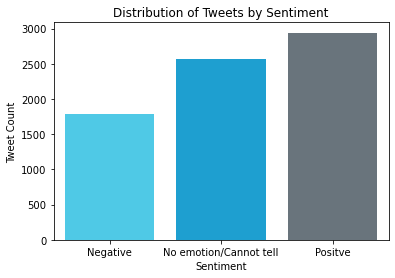

In [343]:
# # Visualizing the combined dataset (initial and synthetic texts) for Apple products only - Sentiment assigned by VADER
#############MP Note - the classes are strings here, not numeric --
fig, ax = plt.subplots()

custom_palette = ['#36d8ff', '#00acee', '#66757f']

classes = [0, 1, 2]
#classes = ["0", "1", "2"]
sns.countplot(x='emotion', data=df_combo, palette=custom_palette, order=classes)

ax.set(xticklabels=['Negative', 'No emotion/Cannot tell', 'Positve'], 
       xlabel='Sentiment', ylabel='Tweet Count', title='Distribution of Tweets by Sentiment')

plt.savefig('images/fig2.png', dpi=200, transparent=True)
plt.show()

In [232]:
df_combo["emotion"].value_counts()

2    2942
1    2571
0    1793
Name: emotion, dtype: int64

In [233]:
# Updating the data type to an integer
df_combo['emotion']=df_combo['emotion'].astype(np.int64)

In [234]:
df_combo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7306 entries, 0 to 1767
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   tweet_text      7306 non-null   object 
 1   product         7306 non-null   object 
 2   sentiment       7306 non-null   object 
 3   compound_score  7306 non-null   float64
 4   emotion         7306 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 502.5+ KB


In [235]:
# Sampling 1500 tweets from each of the three sentiment category
df_combo_neg_sample = df_combo[df_combo['emotion'] == 0].sample(n=1500)
df_combo_neutral_sample = df_combo[df_combo['emotion'] == 1].sample(n=1500)
df_combo_pos_sample = df_combo[df_combo['emotion'] == 2].sample(n=1500)

In [236]:
df_combo_neg_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1500 entries, 1237 to 236
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   tweet_text      1500 non-null   object 
 1   product         1500 non-null   object 
 2   sentiment       1500 non-null   object 
 3   compound_score  1500 non-null   float64
 4   emotion         1500 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 70.3+ KB


In [237]:
df_combo_neutral_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1500 entries, 6238 to 6334
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   tweet_text      1500 non-null   object 
 1   product         1500 non-null   object 
 2   sentiment       1500 non-null   object 
 3   compound_score  1500 non-null   float64
 4   emotion         1500 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 70.3+ KB


In [238]:
df_combo_pos_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1500 entries, 7445 to 8929
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   tweet_text      1500 non-null   object 
 1   product         1500 non-null   object 
 2   sentiment       1500 non-null   object 
 3   compound_score  1500 non-null   float64
 4   emotion         1500 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 70.3+ KB


In [239]:
# Recombining the three sentiment datasets into a single balanced dataset
df_combo_sample = pd.concat([df_combo_neg_sample, df_combo_neutral_sample, df_combo_pos_sample], axis=0)

In [240]:
df_combo_sample.head()

,tweet_text,product,sentiment,compound_score,emotion
1237,"""The iPad 2 is a disappointment. Expected more...",Apple,"{'neg': 0.184, 'neu': 0.724, 'pos': 0.093, 'co...",-0.3892,0
8430,@mention The geeks need somewhere downtown to ...,Apple,"{'neg': 0.072, 'neu': 0.928, 'pos': 0.0, 'comp...",-0.1027,0
1534,AirPods falling out of my ears more often than...,Apple,"{'neg': 0.236, 'neu': 0.764, 'pos': 0.0, 'comp...",-0.4019,0
7452,Special Apple store at #sxsw just for ipad. Li...,Apple,"{'neg': 0.156, 'neu': 0.699, 'pos': 0.145, 'co...",-0.0516,0
4530,Some iPhone art I accidentally made {link} #sxsw,Apple,"{'neg': 0.255, 'neu': 0.745, 'pos': 0.0, 'comp...",-0.3400,0


In [241]:
df_combo_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4500 entries, 1237 to 8929
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   tweet_text      4500 non-null   object 
 1   product         4500 non-null   object 
 2   sentiment       4500 non-null   object 
 3   compound_score  4500 non-null   float64
 4   emotion         4500 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 210.9+ KB


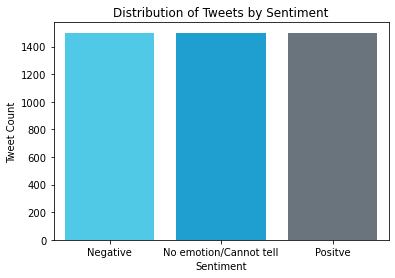

In [242]:
# Balanced distribution of sentiment for Apple products
fig, ax = plt.subplots()

classes = [0, 1, 2]

custom_palette = ['#36d8ff', '#00acee', '#66757f']
sns.countplot(x='emotion', data=df_combo_sample, palette=custom_palette, order=classes)

ax.set(xticklabels=['Negative', 'No emotion/Cannot tell', 'Positve'], 
       xlabel='Sentiment', ylabel='Tweet Count', title='Distribution of Tweets by Sentiment')

plt.savefig('images/fig3.png', dpi=200, transparent=True)
plt.show()

In [243]:
df_combo_sample['emotion'].value_counts(normalize=True)

2    0.333333
1    0.333333
0    0.333333
Name: emotion, dtype: float64

In [244]:
# Clean up dataset to only include tweet text and emotion
columns_to_drop = ['sentiment', 'compound_score', 'product']
df_combo_sample.drop(columns=columns_to_drop, inplace=True)

### Word Frequencies by Sentiment

### Positive Sentiment

In [245]:
# Looking at the positve sentiment dataset only
df_combo_pos_sample.drop(columns=columns_to_drop, inplace=True)

In [246]:
# Defining X and y
X=df_combo_pos_sample["tweet_text"]
y=df_combo_pos_sample["emotion"]

In [247]:
sw = stopwords.words('english')

In [248]:
# Adding stopwords based on the dataset
sw.extend(["apple", "sxsw", "mention", "rt", "link", "new", "get", "line", "go", "use", "one", "via", "need", "would", "try", "come", "day", "give", "see", "know", "sxswi", "th", "even", "guy", "say"])

In [249]:
def get_wordnet_pos(tweet_tag):
    '''
    We are converting nltk positional tags to wordnet tags
    '''
    if tweet_tag.startswith('J'):
        return wordnet.ADJ
    elif tweet_tag.startswith('V'):
        return wordnet.VERB
    elif tweet_tag.startswith('N'):
        return wordnet.NOUN
    elif tweet_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [250]:
def tweet_preparer(tweet, stop_words=sw):
    '''
    
    :param tweet: a tweet from the SXSW dataset 
    :return: a tweet string with words which have been 
            lemmatized, 
            parsed for stopwords, 
            made lowercase,
            and stripped of punctuation and numbers.
    '''
    
    regex_token = RegexpTokenizer(r"([a-zA-Z]+(?:’[a-z]+)?)") 
    tweet = regex_token.tokenize(tweet)
    tweet = [word.lower() for word in tweet]
    tweet = [word for word in tweet if word not in sw]
    # print(tweet)
    tweet = pos_tag(tweet)
    tweet = [(word[0], get_wordnet_pos(word[1])) for word in tweet]
    lemmatizer = WordNetLemmatizer() 
    tweet = [lemmatizer.lemmatize(word[0], word[1]) for word in tweet]
    return ' '.join(tweet)

In [251]:
token_tweets = [tweet_preparer(tweet, sw) for tweet in X]

In [252]:
token_tweets

['nice make lot sell sure popup store',
 'wishful several semi fill ipad surround tech geek mass grab box amp bump pay synching joy ensues',
 'never forget march weekend japan earthquake ipad first south southwest memolane',
 'anyone quot popup quot store downtown austin ipad purchase',
 'iphone autocorrect turn soon spoon thanks make sound like lunatic autocorrectfail',
 'hold iphone use change visuals googledoodle fun panel intrigue marcin powerglove',
 'go emc consult booth chance win ipad',
 'iphone evidence might well call country united state sxswsa',
 'ipod nano gen screen small enjoyable miss mark ipodnano letdown',
 'tech begin win past week major dilemma technology',
 'yes design win isack soo cool',
 'quot open pop store austin nerd town ipads wow',
 'wjchat q go iphone ipad buy zagg keyboard high hope plan work',
 'ipod nano gen screen small enjoyable miss mark ipodnano letdown',
 'accidentally activate siri crowd room everyone star like summon demon thanks sirisocialawkwar

In [253]:
# Instantiating Count Vectorizer
cv=CountVectorizer()

In [254]:
# Fitting and transforming
X_vec_pos = cv.fit_transform(token_tweets)
X_vec_pos = pd.DataFrame.sparse.from_spmatrix(X_vec_pos)
X_vec_pos.columns = sorted(cv.vocabulary_)
X_vec_pos.set_index(y.index, inplace=True)

In [255]:
token_tweets_test = [tweet_preparer(tweet, sw) for tweet in X]

In [256]:
word_frequencies = X_vec_pos.sum(axis=0)

# Convert to DataFrame and transpose
word_frequencies_df = pd.DataFrame(word_frequencies, columns=['Frequency'])
word_frequencies_df.index.name = 'Word'

# Sort by frequency in descending order
word_frequencies_df = word_frequencies_df.sort_values(by='Frequency', ascending=False)

# Get the most common words and their frequencies
most_common_words = word_frequencies_df.head(80)

# Print the most common words and their frequencies
print(most_common_words)

          Frequency
Word               
ipad            721
iphone          445
store           243
quot            206
app             180
...             ...
nice             25
tweet            24
download         24
relief           24
take             24

[80 rows x 1 columns]


In [257]:
#!pip install wordcloud

In [258]:
#!pip install --upgrade pip

In [259]:
#!pip install --upgrade Pillow

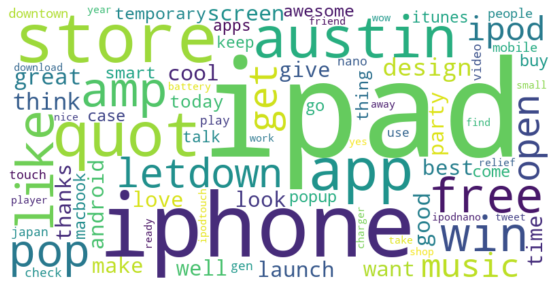

In [260]:
# Convert the most common words DataFrame to a dictionary
word_freq_dict = most_common_words['Frequency'].to_dict()

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', font_path=None).generate_from_frequencies(word_freq_dict)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

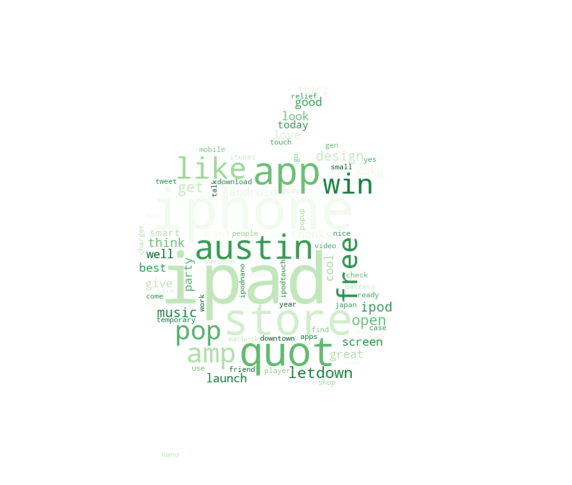

In [261]:
# Convert the most common words DataFrame to a dictionary
word_freq_dict = most_common_words['Frequency'].to_dict()

colormap = 'Greens'

current_dir = os.getcwd()

# Load the mask image
mask_image_path = os.path.join(current_dir, 'images', 'Apple_black_white_20240507.jpg')
mask_image = np.array(Image.open(mask_image_path))

# Generate word cloud with the mask image
wordcloud = WordCloud(mask=mask_image, background_color='white', colormap=colormap).generate_from_frequencies(word_freq_dict)

# Display the word cloud
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### Negative Sentiment

In [262]:
# Looking at the negative sentiment dataset only
df_combo_neg_sample.drop(columns=columns_to_drop, inplace=True)

In [263]:
# Defining X and y
X=df_combo_neg_sample["tweet_text"]
y=df_combo_neg_sample["emotion"]

In [266]:
def get_wordnet_pos(tweet_tag):
    '''
    We are converting nltk positional tags to wordnet tags
    '''
    if tweet_tag.startswith('J'):
        return wordnet.ADJ
    elif tweet_tag.startswith('V'):
        return wordnet.VERB
    elif tweet_tag.startswith('N'):
        return wordnet.NOUN
    elif tweet_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [267]:
def tweet_preparer(tweet, stop_words=sw):
    '''
    
    :param tweet: a tweet from the SXSW dataset 
    :return: a tweet string with words which have been 
            lemmatized, 
            parsed for stopwords, 
            made lowercase,
            and stripped of punctuation and numbers.
    '''
    
    regex_token = RegexpTokenizer(r"([a-zA-Z]+(?:’[a-z]+)?)") 
    tweet = regex_token.tokenize(tweet)
    tweet = [word.lower() for word in tweet]
    tweet = [word for word in tweet if word not in sw]
    # print(tweet)
    tweet = pos_tag(tweet)
    tweet = [(word[0], get_wordnet_pos(word[1])) for word in tweet]
    lemmatizer = WordNetLemmatizer() 
    tweet = [lemmatizer.lemmatize(word[0], word[1]) for word in tweet]
    return ' '.join(tweet)

In [268]:
token_tweets = [tweet_preparer(tweet, sw) for tweet in X]

In [269]:
token_tweets

['ipad disappointment expect flagship tablet ipad letdown',
 'geek somewhere downtown ipad drop',
 'airpods fall ear often drop key airpodsissues',
 'special store ipad block long',
 'iphone art accidentally make',
 'ipod shuffle lack screen control make frustrate experience ipodshuffle letdown',
 'repair cost outrageous practically force buy device instead fix applecosts',
 'store insane',
 'geek leave austin music people hit town look feel becomes unique less branded',
 'ipod nano generation disappointment sure small lack physical control make frustrate clip design impractical ipodnano disappointing',
 'siri misunderstand feature bug applesirisilliness',
 'look stupid take pix ipad believe guy',
 'ipod shuffle lack screen control make frustrate ipodshuffle letdown',
 'lack customization option ios limit user control device applecontrol',
 'macbook air sacrifice much thinness worth compromise macbookair letdown',
 'think ipod touch game changer battery drainer ipodtouch disappointed',

In [270]:
# Instantiating Count Vectorizer
cv=CountVectorizer()

In [271]:
# Fitting and transoforming
X_vec_neg = cv.fit_transform(token_tweets)
X_vec_neg = pd.DataFrame.sparse.from_spmatrix(X_vec_neg)
X_vec_neg.columns = sorted(cv.vocabulary_)
X_vec_neg.set_index(y.index, inplace=True)

In [272]:
token_tweets_test = [tweet_preparer(tweet, sw) for tweet in X]

In [273]:
word_frequencies = X_vec_neg.sum(axis=0)

# Convert to DataFrame and transpose
word_frequencies_df = pd.DataFrame(word_frequencies, columns=['Frequency'])
word_frequencies_df.index.name = 'Word'

# Sort by frequency in descending order
word_frequencies_df = word_frequencies_df.sort_values(by='Frequency', ascending=False)

# Get the most common words and their frequencies
most_common_words = word_frequencies_df.head(80)

# Print the most common words and their frequencies
print(most_common_words)

            Frequency
Word                 
iphone            535
ipad              489
disappoint        305
macbook           235
letdown           168
...               ...
bad                30
poor               30
lose               30
tablet             30
thing              30

[80 rows x 1 columns]


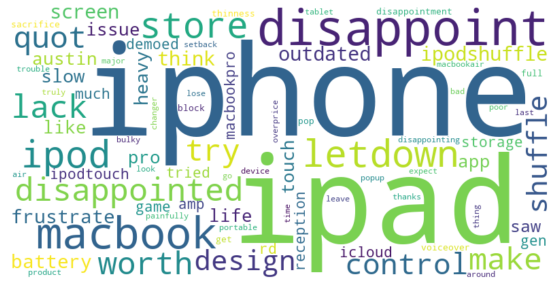

In [274]:
# Convert the most common words DataFrame to a dictionary
word_freq_dict = most_common_words['Frequency'].to_dict()

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', font_path=None).generate_from_frequencies(word_freq_dict)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

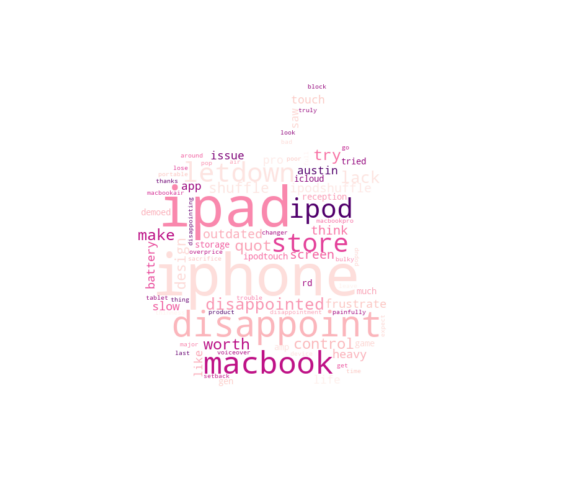

In [275]:
# Convert the most common words DataFrame to a dictionary
word_freq_dict = most_common_words['Frequency'].to_dict()

colormap = 'RdPu'
current_dir = os.getcwd()

# Load the mask image
mask_image_path = os.path.join(current_dir, 'images', 'Apple_black_white_20240507.jpg')
mask_image = np.array(Image.open(mask_image_path))

# Generate word cloud with the mask image
wordcloud = WordCloud(mask=mask_image, background_color='white', colormap=colormap).generate_from_frequencies(word_freq_dict)

# Display the word cloud
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### Neutral Sentiment

In [276]:
# Looking at the neutral sentiment dataset only
df_combo_neutral_sample.drop(columns=columns_to_drop, inplace=True)

In [277]:
# Defining X and y
X=df_combo_neutral_sample["tweet_text"]
y=df_combo_neutral_sample["emotion"]

In [280]:
def get_wordnet_pos(tweet_tag):
    '''
    We are converting nltk positional tags to wordnet tags
    '''
    if tweet_tag.startswith('J'):
        return wordnet.ADJ
    elif tweet_tag.startswith('V'):
        return wordnet.VERB
    elif tweet_tag.startswith('N'):
        return wordnet.NOUN
    elif tweet_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [281]:
def tweet_preparer(tweet, stop_words=sw):
    '''
    
    :param tweet: a tweet from the SXSW dataset 
    :return: a tweet string with words which have been 
            lemmatized, 
            parsed for stopwords, 
            made lowercase,
            and stripped of punctuation and numbers.
    '''
    
    regex_token = RegexpTokenizer(r"([a-zA-Z]+(?:’[a-z]+)?)") 
    tweet = regex_token.tokenize(tweet)
    tweet = [word.lower() for word in tweet]
    tweet = [word for word in tweet if word not in sw]
    # print(tweet)
    tweet = pos_tag(tweet)
    tweet = [(word[0], get_wordnet_pos(word[1])) for word in tweet]
    lemmatizer = WordNetLemmatizer() 
    tweet = [lemmatizer.lemmatize(word[0], word[1]) for word in tweet]
    return ' '.join(tweet)

In [282]:
token_tweets = [tweet_preparer(tweet, sw) for tweet in X]

In [283]:
token_tweets

['last year single ipad public today common laptop see android tablet',
 'already see ipad place',
 'monday adfonic daily read iphone white release google social thing mobile',
 'schedule heavy laptop ipad already',
 'anyone temporary store austin idea till late open tonight',
 'meet store',
 'brought water ipad',
 'novelty ipad news apps fade fast among delegate',
 'quot learn thing screen quot year old explanation instantly know ipad',
 'debut iphone amp droid app next year make phone waterproof amp light cigarette',
 'store peep run high fiving open sec enuf u chump ipad',
 'omfg hear pop store downtown austin pic already gowalla ipad',
 'iphone app control mania half screen use button filter half content ui fail',
 'open pop store austin apps mobile',
 'justmet work year',
 'notetaking bingo pull ipad moleskin',
 'record experience iphone',
 'mom ipad design boomer',
 'pop store austin peep store finish brand power',
 'trend tomlinson see age ipad owner higher expect say demo newsa

In [284]:
# Instantiating Count Vectorizer
cv=CountVectorizer()

In [285]:
# Fitting and Transforming
X_vec_neutral = cv.fit_transform(token_tweets)
X_vec_neutral = pd.DataFrame.sparse.from_spmatrix(X_vec_neutral)
X_vec_neutral.columns = sorted(cv.vocabulary_)
X_vec_neutral.set_index(y.index, inplace=True)

In [286]:
token_tweets_test = [tweet_preparer(tweet, sw) for tweet in X]

In [287]:
word_frequencies = X_vec_neutral.sum(axis=0)

# Convert to DataFrame and transpose
word_frequencies_df = pd.DataFrame(word_frequencies, columns=['Frequency'])
word_frequencies_df.index.name = 'Word'

# Sort by frequency in descending order
word_frequencies_df = word_frequencies_df.sort_values(by='Frequency', ascending=False)

# Get the most common words and their frequencies
most_common_words = word_frequencies_df.head(80)

# Print the most common words and their frequencies
print(most_common_words)

        Frequency
Word             
ipad          723
store         527
iphone        355
austin        250
pop           229
...           ...
siri           21
long           21
say            21
keep           21
live           20

[80 rows x 1 columns]


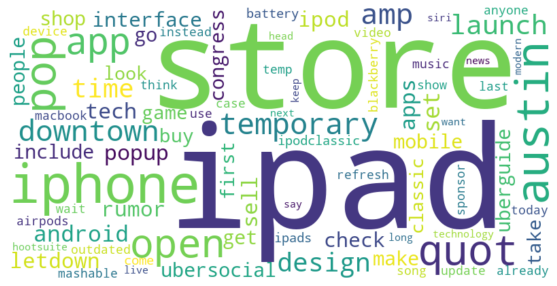

In [288]:
# Convert the most common words DataFrame to a dictionary
word_freq_dict = most_common_words['Frequency'].to_dict()

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', font_path=None).generate_from_frequencies(word_freq_dict)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

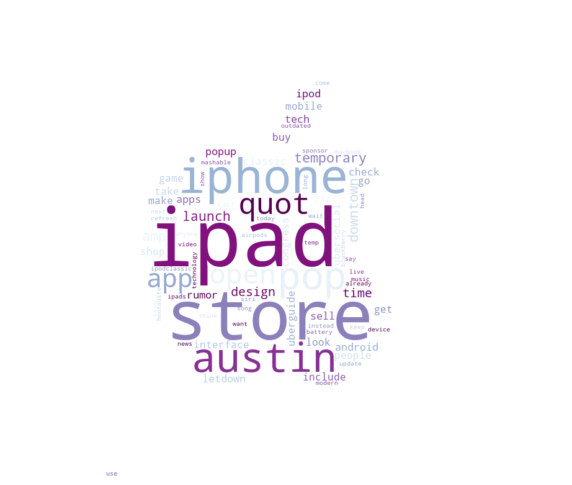

In [289]:
# Convert the most common words DataFrame to a dictionary
word_freq_dict = most_common_words['Frequency'].to_dict()

colormap = 'BuPu'
current_dir = os.getcwd()

# Load the mask image
mask_image_path = os.path.join(current_dir, 'images', 'Apple_black_white_20240507.jpg')
mask_image = np.array(Image.open(mask_image_path))

# Generate word cloud with the mask image
wordcloud = WordCloud(mask=mask_image, background_color='white', colormap=colormap).generate_from_frequencies(word_freq_dict)

# Display the word cloud
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### Train Test Split for Modeling and Pre Processing

In [290]:
# Defining X and y
X=df_combo_sample["tweet_text"]
y=df_combo_sample["emotion"]

In [291]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=42,
                                                    test_size=0.2)

In [294]:
def get_wordnet_pos(tweet_tag):
    '''
    We are converting nltk positional tags to wordnet tags
    '''
    if tweet_tag.startswith('J'):
        return wordnet.ADJ
    elif tweet_tag.startswith('V'):
        return wordnet.VERB
    elif tweet_tag.startswith('N'):
        return wordnet.NOUN
    elif tweet_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [295]:
def tweet_preparer(tweet, stop_words=sw):
    '''
    
    :param tweet: a tweet from the SXSW dataset 
    :return: a tweet string with words which have been 
            lemmatized, 
            parsed for stopwords, 
            made lowercase,
            and stripped of punctuation and numbers.
    '''
    
    regex_token = RegexpTokenizer(r"([a-zA-Z]+(?:’[a-z]+)?)") 
    tweet = regex_token.tokenize(tweet)
    tweet = [word.lower() for word in tweet]
    tweet = [word for word in tweet if word not in sw]
    # print(tweet)
    tweet = pos_tag(tweet)
    tweet = [(word[0], get_wordnet_pos(word[1])) for word in tweet]
    lemmatizer = WordNetLemmatizer() 
    tweet = [lemmatizer.lemmatize(word[0], word[1]) for word in tweet]
    return ' '.join(tweet)

In [296]:
token_tweets = [tweet_preparer(tweet, sw) for tweet in X_train]

In [297]:
token_tweets

['get flask amp ipad yes sit st wait aicn screening prepared iloveasurprise',
 'sure stop booth today show game run ipad could free gift',
 'pass homeless w sign save ipad',
 'put ipad idiot smcomedyfyeah',
 'airpods battery life short attention span shortbatterylife',
 'ipod shuffle lack screen control make frustrate ipodshuffle letdown',
 'multiple ipad crazy',
 'party hangover time confuse stumble quot ipad interface amp navigation structure quot bliss fb',
 'stock like slim',
 'save set open pop store',
 'news get music business device call quot ipod quot like compact disc player without disk',
 'sign plane two iphone user arcade fire ring letsdothis',
 'ipod shuffle lack screen control make frustrate ipodshuffle letdown',
 'obsession thinness sacrifice battery life durability u product last look sleek priority appleproducts',
 'congress nice set open popup shop core action',
 'fancy verizon g bb card keep drop amp iphone rock steady gofigure',
 'ipod touch promised much iphone wit

#### We are beginnng with a Count Vectorizer because we are most interested in overall counts and less concerned about weighting words that are unique throughout the entire dataset.

In [298]:
X_train.head()

2117    Got my flask &amp; my iPad . Yes,  I'm sitting...
4874    Be sure to stop by our SXSW booth today. Show ...
2816    Just passed a homeless w a sign: 'Saving for I...
7335        Put the iPad down idiot! #SMComedyFyeah #SxSW
281     AirPods battery life shorter than my attention...
Name: tweet_text, dtype: object

In [300]:
# Instantiating Count Vectorizer
cv=CountVectorizer()

In [301]:
# Fitting and transforming the X_train
X_train_vec = cv.fit_transform(token_tweets)
X_train_vec = pd.DataFrame.sparse.from_spmatrix(X_train_vec)
X_train_vec.columns = sorted(cv.vocabulary_)
X_train_vec.set_index(y_train.index, inplace=True)

In [302]:
token_tweets_test = [tweet_preparer(tweet, sw) for tweet in X_test]

In [303]:
# Transforming the X_test
X_test_vec = cv.transform(token_tweets_test)
X_test_vec = pd.DataFrame.sparse.from_spmatrix(X_test_vec)
X_test_vec.columns = sorted(cv.vocabulary_)
X_test_vec.set_index(y_test.index, inplace=True)

In [304]:
X_train_vec.head()

,aapl,aarpbulletin,ab,abacus,abandon,aber,able,abnormal,absolutely,absolutley,...,zeldman,zero,zip,zms,zombie,zomg,zoom,zuckerberg,zynga,zzzs
2117,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4874,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2816,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7335,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
281,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [305]:
# Instantiating a Multinomial Naive Bayes model
mnb = MultinomialNB()

In [306]:
# Fitting the vectorized X and y train data to the model
mnb.fit(X_train_vec, y_train)

MultinomialNB()

In [307]:
# Predicting the y from the vectorized X_test data
y_pred=mnb.predict(X_test_vec)

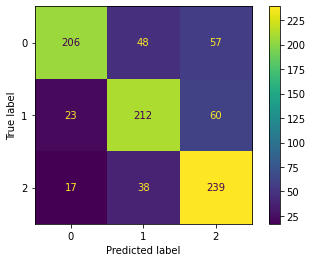

In [308]:
# Create and plot a confusion matrix to evaluate model performance
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(mnb, X_test_vec, y_test );

In [310]:
# Additional model evaluation
accuracy_score(y_test, y_pred)

In [311]:
# Additional model evaluation
precision_score(y_test, y_pred, average='weighted')

In [312]:
# Additional model evaluation
recall_score(y_test, y_pred, average='weighted')

In [345]:
# Determine the most common words in the dataset
word_frequencies = X_train_vec.sum(axis=0)

# Convert to DataFrame and transpose
word_frequencies_df = pd.DataFrame(word_frequencies, columns=['Frequency'])
word_frequencies_df.index.name = 'Word'

# Sort by frequency in descending order
word_frequencies_df = word_frequencies_df.sort_values(by='Frequency', ascending=False)

# Get the most common words and their frequencies
most_common_words = word_frequencies_df.head(30)

# Print the most common words and their frequencies
print(most_common_words)

            Frequency
Word                 
ipad             1561
iphone           1065
store             751
quot              430
austin            395
app               313
pop               303
letdown           250
open              244
disappoint        243
ipod              234
macbook           227
amp               215
design            186
make              166
like              156
get               141
think             136
temporary         136
launch            130
time              126
downtown          114
screen            114
lack              109
battery           109
try               104
music             104
win               103
popup             101
go                100


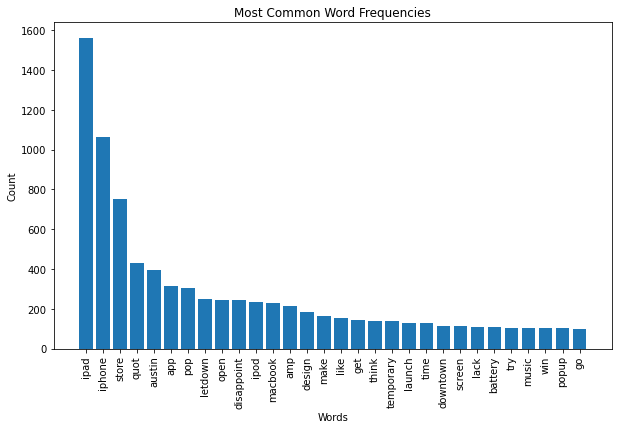

In [314]:
# Visaulize the most common words
most_common_words = word_frequencies_df.head(30)
words = most_common_words.index
counts = most_common_words['Frequency']

plt.figure(figsize=(10, 6))
plt.bar(range(len(words)), counts, tick_label=words)
plt.xlabel('Words')
plt.ylabel('Count')
plt.title('Most Common Word Frequencies')
plt.xticks(rotation=90)
plt.show()

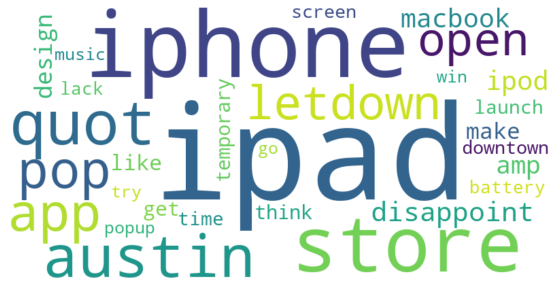

In [315]:
# Convert the most common words DataFrame to a dictionary
word_freq_dict = most_common_words['Frequency'].to_dict()

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', font_path=None).generate_from_frequencies(word_freq_dict)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

#### We explored a TF-IDF Vectorizer to look at the impact of weighting more unique words across the dataset.  

In [316]:
# Instantiating the TF-IDF Vectorizer
tfidf = TfidfVectorizer()

In [317]:
# Fitting and transforming the X_train
X_train_vec_tfidf = tfidf.fit_transform(token_tweets)
X_train_vec_tfidf = pd.DataFrame.sparse.from_spmatrix(X_train_vec_tfidf)
X_train_vec_tfidf.columns = sorted(tfidf.vocabulary_)
X_train_vec_tfidf.set_index(y_train.index, inplace=True)

In [318]:
token_tweets_test = [tweet_preparer(tweet, sw) for tweet in X_test]

In [319]:
# Transforming the X_test
X_test_vec_tfidf = tfidf.transform(token_tweets_test)
X_test_vec_tfidf = pd.DataFrame.sparse.from_spmatrix(X_test_vec_tfidf)
X_test_vec_tfidf.columns = sorted(tfidf.vocabulary_)
X_test_vec_tfidf.set_index(y_test.index, inplace=True)

In [320]:
X_train_vec_tfidf.head()

,aapl,aarpbulletin,ab,abacus,abandon,aber,able,abnormal,absolutely,absolutley,...,zeldman,zero,zip,zms,zombie,zomg,zoom,zuckerberg,zynga,zzzs
2117,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4874,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2816,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7335,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
281,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [321]:
# Instantiating a Multinomial Naive Bayes model
mnb2 = MultinomialNB()

In [322]:
# Fitting the vectorized X and y train data to the model
mnb2.fit(X_train_vec_tfidf, y_train)

MultinomialNB()

In [323]:
# Predicting the y from the vectorized X_test data
y_pred2=mnb2.predict(X_test_vec_tfidf)

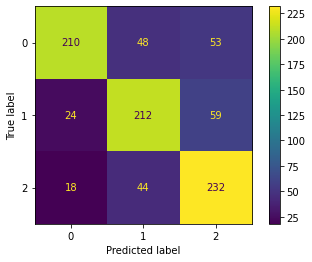

In [324]:
# Create and plot a confusion matrix to evaluate model performance
cm2 = confusion_matrix(y_test, y_pred2)
plot_confusion_matrix(mnb2, X_test_vec_tfidf, y_test );

In [326]:
# Additional model evaluation
accuracy_score(y_test, y_pred2)

0.7266666666666667

In [327]:
# Additional model evaluation
precision_score(y_test, y_pred2, average='weighted')

0.736854911827372

In [328]:
# Additional model evaluation
recall_score(y_test, y_pred2, average='weighted')

0.7266666666666667

In [329]:
# Assuming X_train_vec is your vectorized dataset (e.g., using CountVectorizer)
word_frequencies_tfidf = X_train_vec_tfidf.sum(axis=0)

# Convert to DataFrame and transpose
word_frequencies_df2 = pd.DataFrame(word_frequencies_tfidf, columns=['Frequency'])
word_frequencies_df2.index.name = 'Word'

# Sort by frequency in descending order
word_frequencies_df2 = word_frequencies_df2.sort_values(by='Frequency', ascending=False)

# Get the most common words and their frequencies
most_common_words2 = word_frequencies_df2.head(30)

# Print the most common words and their frequencies
print(most_common_words2)

               Frequency
Word                    
ipad          196.246487
iphone        150.507721
store         148.370749
austin         89.701800
quot           85.232747
pop            79.660804
open           70.002383
app            63.369266
letdown        58.825855
disappoint     57.730991
macbook        56.190735
ipod           55.138239
temporary      46.074588
design         44.628446
amp            44.231608
launch         40.825207
make           39.223716
downtown       38.847974
think          36.027358
like           35.262781
get            33.865166
popup          32.516538
time           32.479569
screen         30.572858
win            30.354047
try            30.060770
disappointed   30.051430
outdated       29.183050
control        29.112267
battery        27.764656


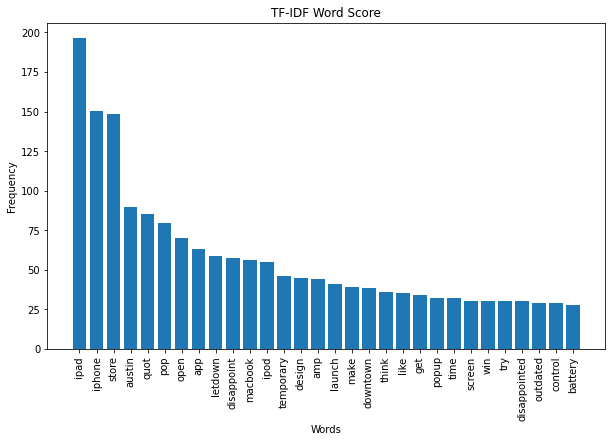

In [330]:
# Extract words and their counts from most_common_words DataFrame
most_common_words2= word_frequencies_df2.head(30)
words = most_common_words2.index
counts = most_common_words2['Frequency']

plt.figure(figsize=(10, 6))
plt.bar(range(len(words)), counts, tick_label=words)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('TF-IDF Word Score')
plt.xticks(rotation=90)
plt.show()

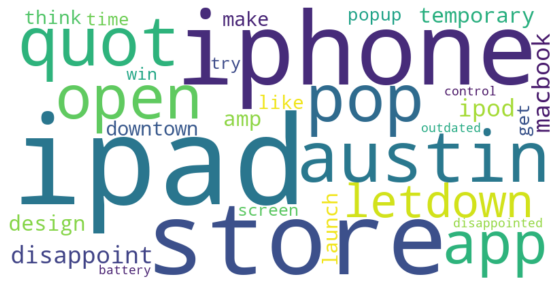

In [331]:
# Convert the most common words DataFrame to a dictionary
word_freq_dict = most_common_words2['Frequency'].to_dict()

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', font_path=None).generate_from_frequencies(word_freq_dict)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [332]:
# Creating a grid search to find the best hyperparameters to include in the model
grid = {'n_estimators': [500, 1000, 1500],
       'max_depth': [8, 10, 12, 14],
        'max_features': [3, 6, 9]
                }

In [ ]:
# Instantiating a random forest classifier
rf_clf = RandomForestClassifier(random_state=42)

In [333]:
#grid_search = GridSearchCV(estimator=rf_clf, param_grid=grid, cv=5, scoring='accuracy')
#grid_search.fit(X_train_vec, y_train)

In [334]:
grid_search.best_params_

{'max_depth': 14, 'max_features': 3, 'n_estimators': 1500}

In [335]:
grid_search.best_score_

0.736111111111111

In [336]:
# Running the Random Forest Classifier with the best parameters from the grid search; using the count vectorized data
rf = RandomForestClassifier(n_estimators=1000, max_features=9, max_depth=14, random_state=42)
rf.fit(X_train_vec, y_train)
y_pred = rf.predict(X_test_vec)
precision_score(y_test, y_pred, average="weighted")

0.7961691041468819

In [337]:
#grid_search = GridSearchCV(estimator=rf_clf, param_grid=grid, cv=5, scoring='accuracy')
#grid_search.fit(X_train_vec_tfidf, y_train)

In [338]:
grid_search.best_params_

{'max_depth': 14, 'max_features': 3, 'n_estimators': 1500}

In [339]:
grid_search.best_score_

0.736111111111111

In [340]:
# Running the Random Forest Classifier with the best parameters from the grid search; using the TF-IDF vectorized data
rf = RandomForestClassifier(n_estimators=1500, max_features=3, max_depth=14, random_state=42)
rf.fit(X_train_vec_tfidf, y_train)
y_pred = rf.predict(X_test_vec_tfidf)
precision_score(y_test, y_pred2, average="weighted")

0.736854911827372

Monica's notes to self

- used Vader, but it did not seem to classify well after spot checking
- were there duplicates in the original dataset?
